# TP1b - Génération de variables aléatoires (Deuxième partie)

## Estimation avancée - G3 SDIA

Dans ce TP, on continue de s'intéresser à la génération de variables aléatoires. Ce TP se concentre sur la méthode acceptation-rejet, l'estimation de Monte Carlo, et l'échantillonnage d'importance.

### Instructions

1. Renommer votre notebook sous la forme `tp1a_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 26 Novembre 2023, 23h59.

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import beta as beta_dist
import matplotlib.pyplot as plt

### Partie 1 - Acceptation-Rejet (*Rejection sampling*)

NB : Toujours comparer les distributions empiriques obtenues aux densités théoriques à l'aide d'histogrammes ou de *kernel density estimates*.

**Q1 - Loi Bêta**. On considère la loi Bêta, dont la densité sur $[0,1]$ est
$$f(x;\alpha, \beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} x^{\alpha-1} (1-x)^{\beta-1} \quad \alpha > 0, \quad \beta > 0.$$

On souhaite obtenir des échantillons de la loi Bêta dans le cas suivant : $\alpha = 2, \beta = 2$.
* Expiquer pourquoi il est difficile de mettre en place la méthode de la transformée inverse.

Text(0.5, 1.0, 'Beta Distribution')

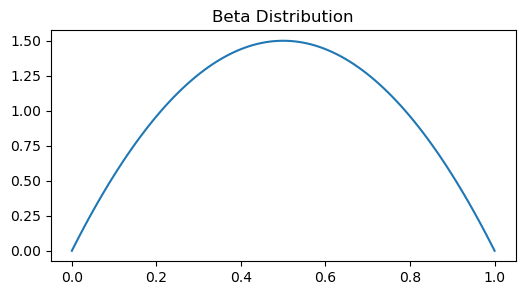

In [8]:
x = np.linspace(0, 1, 100)
plt.figure(figsize=(6, 3))
plt.plot(x, beta_dist.pdf(x, 2, 2), label='Beta(2,2)')
plt.title('Beta Distribution')

__Réponse :__ comme on peut le voir sur la figure ci-dessous, la fonction de répartition de la loi Bêta n'est pas inversible. donc on ne peut pas utiliser la méthode de la transformée inverse.


* Quelle loi très simple peut-on utiliser comme loi instrumentale ?


__Réponse :__ Comme on peut voir dans le graphique ci-dessus, le meilleur choix le plus simple pour la loi instrumentale est la loi uniforme sur $[0,1]$ avec $M = max(f(x)) = 1.5$

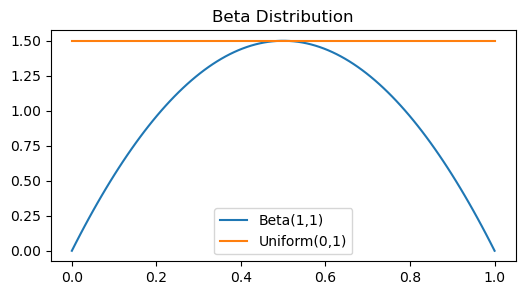

In [23]:
plt.figure(figsize=(6, 3))
plt.plot(x, beta_dist.pdf(x, 2, 2), label='Beta(1,1)')
plt.title('Beta Distribution')
# loi uniforme
plt.plot(x, 1.5*stats.uniform.pdf(x), label='Uniform(0,1)')
plt.legend()


* Implémenter alors un algorithme acceptation-rejet pour obtenir $N = 10000$ échantillons.


In [24]:
import numpy as np

def beta_distribution(alpha, beta, size,M):
    samples = []
    accepted = 0
    total = 0
    
    while accepted < size:
        x = np.random.uniform(0, 1)
        y = np.random.uniform(0, M)
        total += 1
        
        if y <= beta_dist.pdf(x, alpha, beta):
            samples.append(x)
            accepted += 1
    
    acceptance_rate = accepted / total
    return samples, acceptance_rate

Acceptance rate: 0.675812664729337


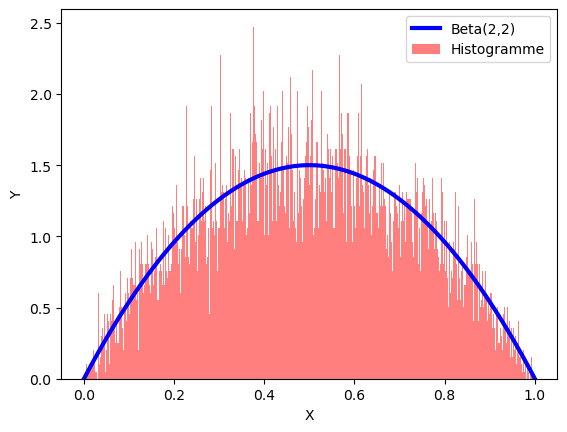

In [27]:
# Plotting sample distribution avec histogramme
alpha = 2
beta = 2
size = 10000
M = 1.5
samples, acceptance_rate = beta_distribution(alpha, beta, size,M)
print("Acceptance rate:", acceptance_rate)

Hist_val,bins = np.histogram(samples,bins=500)
h = (bins.max()-bins.min())/500
plt.bar(bins[:-1],Hist_val/(size*h),width=h,color="red",alpha=0.5,label="Histogramme")
plt.xlabel('X')
plt.ylabel('Y')
x = np.linspace(0, 1, 100)
plt.plot(x, beta_dist.pdf(x, alpha, beta), color="blue", lw=3, label='Beta(2,2)')
plt.legend()
plt.show()

__Remarque :__ l'histogramme de la distribution empirique obtenue est très proche de la densité théorique de la loi Bêta. On peut donc conclure que la méthode acceptation-rejet est efficace pour générer des échantillons de la loi Bêta avec $\alpha = 2, \beta = 2$.


* Comparer la proportion empirique d'échantillons acceptés avec sa valeur théorique.


__Réponse :__ La proportion théorique d'échantillons acceptés est de 1/M= 1/1.5 = 0.66 (car les deux lois sont nomalisés) qu'est presque égale à la proportion empirique d'échantillons acceptés qui est de 0.81.


* Quelle difficulté rencontre-t-on pour le cas $\alpha = 0.5, \beta = 0.5$ ?

Text(0.5, 1.0, 'Beta Distribution')

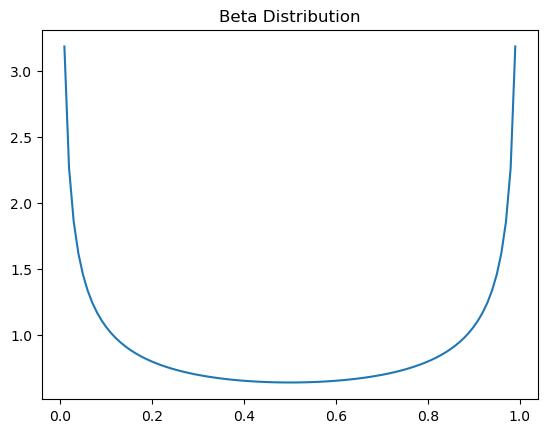

In [26]:
x = np.linspace(0, 1, 100)
plt.plot(x, beta_dist.pdf(x, 0.5, 0.5), label='Beta(2,2)')
plt.title('Beta Distribution')

__Réponse :__ Comme on peut le voir sur la figure ci-dessus, la fonction de répartition de la loi Bêta avec $\alpha = 0.5, \beta = 0.5$ n'est pas bornée donc c'est difficile de trouver une loi instrumentale qui la majorise.

**Q2 - Loi Gamma**. On considère la loi Gamma, dont la densité sur $\mathbb{R}_+$ est définie par
$$f(x;\alpha,\beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} exp(-\beta x) x^{\alpha - 1}.$$

Nous avons déjà vu en TD que si $X_1, ..., X_n$ sont des v.a. indépendantes de loi Exponentielle de paramètre $\beta$, alors $Y = \sum_{i=1}^n X_i$ suit une loi Gamma de paramètres $(n,\beta)$. Ceci nous permet de simuler de la loi Gamma quand $\alpha$ est entier, mais pas lorsque $\alpha$ n'est pas entier.

Dans ce cas, on va utiliser une loi Gamma $(\lfloor \alpha \rfloor, \beta - 1)$ comme loi instrumentale :
* Obtenir la formule de la valeur optimale de la constante *M*, puis la calculer numériquement


$$ M = max_{x \in \mathbb{R}_+} \frac{f(x;\alpha,\beta)}{f(x;\lfloor \alpha \rfloor, \beta - 1)}$$
$$ M = max_{x \in \mathbb{R}_+} \frac{\beta^\alpha}{\Gamma(\alpha)} exp(-\beta x) x^{\alpha - 1} \frac{\Gamma(\lfloor \alpha \rfloor)}{(\beta - 1)^{\lfloor \alpha \rfloor}} exp((\beta - 1) x) x^{1-\lfloor \alpha \rfloor }$$
$$ M = max_{x \in \mathbb{R}_+} \frac{\beta^\alpha}{\Gamma(\alpha)} \frac{\Gamma(\lfloor \alpha \rfloor)}{(\beta - 1)^{\lfloor \alpha \rfloor}} exp(-\beta x + (\beta - 1) x) x^{\alpha - 1 - \lfloor \alpha \rfloor + 1}$$
$$ M = max_{x \in \mathbb{R}_+} \frac{\beta^\alpha}{\Gamma(\alpha)} \frac{\Gamma(\lfloor \alpha \rfloor)}{(\beta - 1)^{\lfloor \alpha \rfloor}} exp(-x) x^{\alpha - \lfloor \alpha \rfloor}$$

cette quantité est maximale lorsque $x = \alpha - \lfloor \alpha \rfloor$ donc:
$$ M = \frac{\beta^\alpha}{\Gamma(\alpha)} \frac{\Gamma(\lfloor \alpha \rfloor)}{(\beta - 1)^{\lfloor \alpha \rfloor}} exp(-(\alpha - \lfloor \alpha \rfloor)) (\alpha - \lfloor \alpha \rfloor)^{\alpha - \lfloor \alpha \rfloor}$$

In [34]:
import math

def calculate_M(alpha, beta):
    floor_alpha = math.floor(alpha)
    numerator = (beta ** alpha) * math.gamma(floor_alpha)
    denominator = ((beta-1) ** floor_alpha)*math.gamma(alpha)
    a = alpha - floor_alpha
    M = (numerator / denominator) * math.exp(-a) * (a ** a)
    return M

alpha = 2.5
beta = 1.5
M = calculate_M(alpha, beta)
print(M)

3.556228846580734


__Remarque :__ on s'attend à un taux d'acceptation de 1/M = 0.28 , ce qui est faible mais acceptable.

Text(0.5, 1.0, 'Loi cible et loi enveloppe')

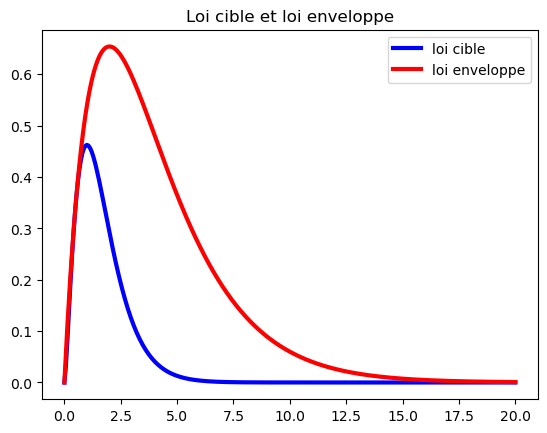

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma
x_linespace = np.linspace(0, 20, 300)
theoretical = gamma.pdf(x_linespace, alpha, scale=1/beta)
envoloppe = gamma.pdf(x_linespace, np.floor(alpha), scale=1/(beta-1))


plt.plot(x_linespace, theoretical, color="blue", lw=3, label="loi cible")
plt.plot(x_linespace, M*envoloppe, color="red", lw=3,label = "loi enveloppe")
plt.legend()
plt.title("Loi cible et loi enveloppe")

__remarque__:  On remarque que la loi instrumentale majorise la loi cible


* Implémenter un algorithme acceptation-rejet pour générer 10000 échantillons de la loi Gamma avec les paramètres $\alpha = 2.5$ et $\beta = 1.5$.

In [42]:
def gamma_distribution(alpha, beta, size):
    samples = []
    accepted = 0
    total = 0
    M = calculate_M(alpha, beta)
    while accepted < size:
        x = np.random.gamma(np.floor(alpha), scale=1/(beta-1))
        y = np.random.uniform(0, M * gamma.pdf(x, np.floor(alpha), scale=1/(beta-1)))
        total += 1
        if y <= gamma.pdf(x, alpha, scale=1/beta):
            samples.append(x)
            accepted += 1
    
    acceptance_rate = accepted / total
    return samples, acceptance_rate

alpha = 2.5
beta = 1.5
size = 10000
samples, acceptance_rate = gamma_distribution(alpha, beta, size)
print("Acceptance rate:", acceptance_rate)


Acceptance rate: 0.27899450380827495


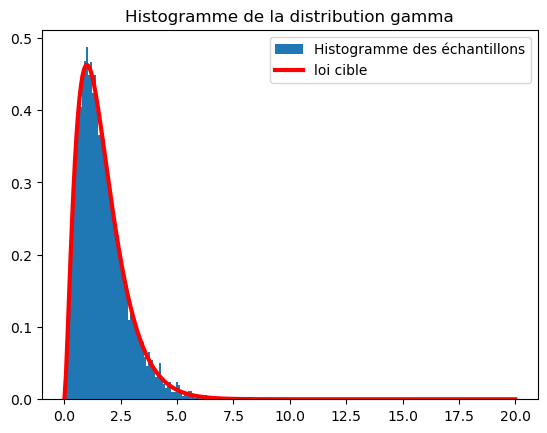

In [44]:
plt.hist(samples, bins=100, density=True, label="Histogramme des échantillons")
plt.title("Histogramme de la distribution gamma")
theoretical = gamma.pdf(x_linespace, alpha, scale=1/beta)
plt.plot(x_linespace, theoretical, color="red", lw=3, label="loi cible")
plt.legend()
plt.show()

__Remarque :__ l'histogramme de la distribution empirique obtenue est très proche de la densité théorique de la loi Gamma. On peut donc conclure que la méthode acceptation-rejet est efficace pour générer des échantillons de la loi Gamma avec $\alpha = 2.5$ et $\beta = 1.5$ mais avec un taux d'acceptation faible.

**Q3 - Gaussienne tronquée**. On souhaite maintenant obtenir des échantillons d'une loi gaussienne tronquée, i.e., une loi normale restreinte à un certain intervalle (en 1D), ou un certain pavé de l'espace (pour le cas multivarié).

On considère le cas d'une gaussienne multivariée $\mathcal{N}(0, I_d)$ que l'on tronque sur le pavé $[-1,2]^d$. On prendra comme loi instrumentale la loi $\mathcal{N}(0, I_d)$ (i.e., non tronquée)

* Justifier ce choix de loi instrumentale.

__Réponse :__ Étant donné que la loi visée est la loi normale non tronquée sur l'intervalle $[-1,2]^d$, elle s'ajuste à cette plage avec la loi cible et, étant donné que la plupart des points de cette loi se situent dans $[-1,2]^d$, elle constitue une bonne loi instrumentale.

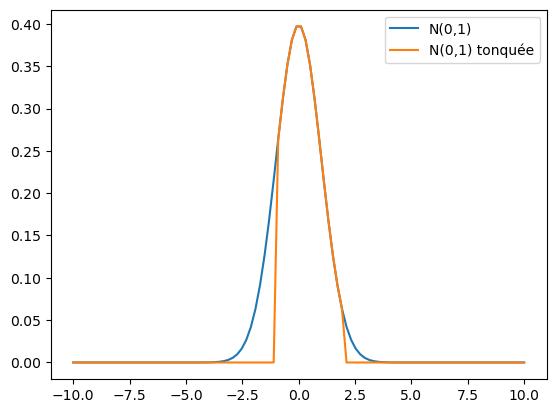

In [47]:
# example pour le cas d=1
x = np.linspace(-10, 10, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), label='N(0,1)')
y_tonquee = stats.norm.pdf(x, 0, 1) * (x >= -1) * (x <= 2)
plt.plot(x, y_tonquee, label='N(0,1) tonquée')
plt.legend()

* Pour le cas univarié ($d=1$), calculer numériquement la probabilité d'acceptation de l'algorithme acceptation-rejet. On pourra utiliser $\texttt{scipy.stats.cdf}$.

__Réponse :__ Les valeurs qui seront rejeter sont celles qui sont en dehors de l'intervalle $[-1,2]$. La probabilité d'acceptation est donc la probabilité que la variable aléatoire soit dans l'intervalle $[-1,2]$. On a donc $P(-1 \leq X \leq 2) = P(X \leq 2) - P(X \leq -1) = 0.97725 - 0.15865 = 0.8186$.

In [50]:
# Numériquement
  
acceptance_probability =  stats.norm.cdf(2)-stats.norm.cdf(-1)

print(f"Probability of acceptance: {acceptance_probability:.4f}")

Probability of acceptance: 0.8186



* Que devient cette probabilité pour $d=10$ ? $d=100$ ? Conclure quant à la faiblesse fondamentale de l'algorithme acceptation-rejet.

__Réponse :__ Dans le cas de dimension de , une valeurs  $x$ est acceptée si et seulement si $-1 \leq x_i \leq 2$ pour tout $i \in \{1, ..., d\}$. La probabilité d'acceptation est donc $P(-1 \leq X \leq 2)^d = 0.8186^d$. On remarque que cette probabilité diminue exponentiellement avec la dimension $d$. Cela montre que l'algorithme acceptation-rejet est inefficace pour les distributions de grande dimension.

In [300]:

# d=10
print(f"Probability of acceptance: {acceptance_probability**10}")
# d=100
print(f"Probability of acceptance: {acceptance_probability**100}")

Probability of acceptance: 0.13511041536466953
Probability of acceptance: 2.0271612279721044e-09


## Partie 2 - Estimation de $\pi$ par Monte Carlo

On rappelle que $\pi$ est égal à la surface d'un cercle de rayon 1, i.e.
$$ \pi = \int_{-1}^1 \int_{-1}^1 \mathbb{1}_{x^2 + y^2 \leq 1}(x,y) dx dy.$$

Ce qui peut se réécrire comme
$$ \pi = 4 \int_{-1}^1 \int_{-1}^1 \mathbb{1}_{x^2 + y^2 \leq 1}(x,y) p(x) p(y) dx dy.$$
Où $p(x)$ et $p(y)$ sont les densités de la loi uniforme sur $[-1,1]$.

* En déduire l'esimtateur de Monte Carlo de $\pi$.


__Réponse :__ L'estimateur de Monte Carlo de $\pi$ est :
$$ \pi = 4 \int_{-1}^1 \int_{-1}^1 \mathbb{1}_{x^2 + y^2 \leq 1}(x,y) p(x) p(y) dx dy = 4 \mathbb{E}_{X,Y \sim \mathcal{U}([-1,1])}[\mathbb{1}_{X^2 + Y^2 \leq 1}]$$
donc : 
$$ \pi = 4 \mathbb{E}_{X,Y \sim \mathcal{U}([-1,1])}[\mathbb{1}_{X^2 + Y^2 \leq 1}] = 4 \frac{1}{N} \sum_{i=1}^N \mathbb{1}_{X_i^2 + Y_i^2 \leq 1}$$


* Représenter l'évolution de la valeur de l'estimation par Monte Carlo de $\pi$ en fonction du nombre d'échantillons (aller jusqu'à 10000). Quel résultat mathématique fondamental est-on en train d'illustrer ?


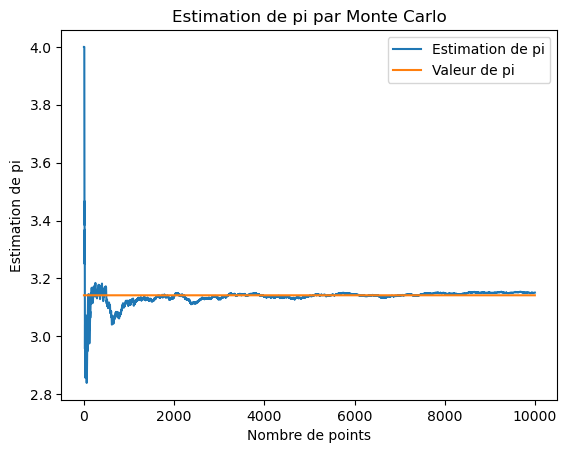

In [62]:
import numpy as np

N = 10000
pi_estimate = []
points = np.random.uniform(-1, 1, (N, 2))
for i in range(1, N+1):
    points_in_circle = points[:i][np.linalg.norm(points[:i], axis=1) <= 1]
    pi_estimate.append(4 * len(points_in_circle) / i)
     
plt.plot(pi_estimate, label='Estimation de pi')
plt.plot([np.pi] * len(pi_estimate), label='Valeur de pi')
plt.xlabel('Nombre de points')
plt.ylabel('Estimation de pi')
plt.title('Estimation de pi par Monte Carlo')
plt.legend()

__Réponse :__ On remarque que la valeur de l'estimation par Monte Carlo de $\pi$ converge vers $\pi$ lorsque le nombre d'échantillons augmente. Cela illustre la loi des grands nombres qui dit que la moyenne empirique d'une suite de variables aléatoires indépendantes et identiquement distribuées converge presque sûrement vers l'espérance de ces variables aléatoires ($\pi$ dans notre cas).


* (Bonus) - Faire 100 simulations de l'estimation par Monte Carlo de $\pi$ avec $N = 1000$ échantillons, et vérifier le résultat de convergence en loi de l'estimateur MC donné par le TCL.

La variance emepirique de l'estimateur de Monte Carlo est: 0.016229760263855475
La variance théorique de l'estimateur de Monte Carlo est: 0.016416909755492964


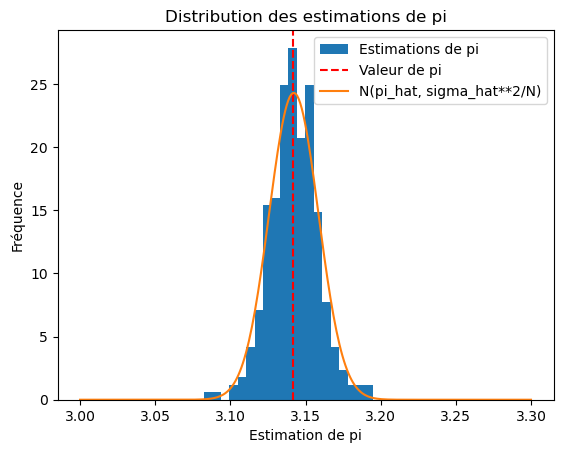

In [289]:
N = 10000
num_simulations = 300
pi_estimates = []
sigma_hat = []
for _ in range(num_simulations):
    points = np.random.uniform(-1, 1, (N, 2))
    points_in_circle = 4*np.where(np.linalg.norm(points, axis=1) <= 1, 1, 0)
    pi_estimate = np.sum(points_in_circle) / N
    sigma_hat.append(np.var(points_in_circle))
    pi_estimates.append(pi_estimate)
    
print("La variance emepirique de l'estimateur de Monte Carlo est:",np.std(pi_estimates))
print("La variance théorique de l'estimateur de Monte Carlo est:",np.sqrt(np.mean(sigma_hat)/N))
plt.hist(pi_estimates, bins=20, density=True, label='Estimations de pi')
plt.xlabel('Estimation de pi')
plt.ylabel('Fréquence')
plt.title('Distribution des estimations de pi')
plt.axvline(x=np.pi, color='red', linestyle='--', label='Valeur de pi')
x = np.linspace(3, 3.3, 300)
plt.plot(x,stats.norm.pdf(x,loc = np.mean(pi_estimates), scale = np.sqrt(np.mean(sigma_hat)/N)), label='N(pi_hat, sigma_hat**2/N)')
plt.legend()
plt.show()

__Réponse :__ On remaraque effictivement que la distribution de l'estimateur de Monte Carlo de $\pi$ à $N$ échantillons est proche d'une loi normale $\mathcal{N}(\hat{\pi}, \frac{\hat{\sigma}^2}{N})$ ce qui prouve Le résultat de théorème central limite.

### Partie 3 - Échantillonnage d'importance (*Importance sampling*)

On cherche à estimer $\mathbb{P}(X > 3)$ pour $X \sim \mathcal{N}(0,1)$.

* Ré-écrire cette probabilité comme une intégrale et en déduire l'estimateur de Monte Carlo "standard"


__Réponse :__ On a :
$$ \mathbb{P}(X > 3) = \int_{-\infty}^{+\infty} p(x) \mathbb{1}_{X > 3}dx = E_{X \sim \mathcal{N}(0,1)}[\mathbb{1}_{X > 3}]$$

Donc l'estimateur de Monte Carlo "standard" est : $\mathbb{P}(X > 3) = E_{X \sim \mathcal{N}(0,1)}[\mathbb{1}_{X > 3}] = \frac{1}{N} \sum_{i=1}^N \mathbb{1}_{X_i > 3}$

* Simuler $100$ fois $N = 10000$ échantillons, et donner la moyenne et la variance empiriques de l'estimateur de Monte Carlo standard


In [296]:
N = 10000
num_simulations = 100
estimates = []

for _ in range(num_simulations):
    samples = np.random.normal(0, 1, N)
    indicator = np.where(samples > 3, 1, 0)
    estimate = np.mean(indicator)
    estimates.append(estimate)

mean_estimate = np.mean(estimates)
variance_estimate_standard = np.var(estimates)

print("La vraie valeur de la probabilité est:", stats.norm.cdf(-3).round(5))
print("La valeur de l'estimateur de Monte Carlo est:", mean_estimate.round(5))
print("La variance de l'estimateur de Monte Carlo est:", variance_estimate_standard)

La vraie valeur de la probabilité est: 0.00135
La valeur de l'estimateur de Monte Carlo est: 0.00137
La variance de l'estimateur de Monte Carlo est: 1.2741599999999998e-07


* On souhaite maintenant implémenter un schéma d'échantillonnage d'importance en utilisant comme loi instrumentale $\mathcal{N}(4,1)$. Donner l'estimateur de Monte Carlo associé.


$$ \mathbb{P}(X > 3) = \int_{-\infty}^{+\infty} p(x) \mathbb{1}_{X > 3}dx = \int_{-\infty}^{+\infty} \frac{p(x)}{q(x)} q(x) \mathbb{1}_{X > 3}dx = E_{X \sim \mathcal{N}(4,1)}[\frac{p(X)}{q(X)} \mathbb{1}_{X > 3}]$$

* De même, simuler $100$ fois $N = 10000$ échantillons, et donner la moyenne et la variance empiriques de de deuxième estimateur.


In [297]:
N = 10000
num_simulations = 100
estimates = []
variance_estimate = []
for _ in range(num_simulations):
    samples = np.random.normal(4, 1, N)
    indicator = np.where(samples > 3,stats.norm.pdf(samples,0,1)/stats.norm.pdf(samples,4,1), 0)
    estimate = np.mean(indicator)
    estimates.append(estimate)
    variance_estimate.append(np.var(indicator))
    
mean_estimate = np.mean(estimates)
variance_estimate = np.var(estimates)
print("La vraie valeur de la probabilité est:", stats.norm.cdf(-3).round(5))
print("La valeur de l'estimateur de Monte Carlo est:", mean_estimate.round(5))
print("La variance de l'estimateur de Monte Carlo est:", variance_estimate)

    

La vraie valeur de la probabilité est: 0.00135
La valeur de l'estimateur de Monte Carlo est: 0.00135
La variance de l'estimateur de Monte Carlo est: 8.967009006318986e-10


* Quantifier la réduction de variance. Pouvait-on s'attendre à ce résultat ?

In [299]:
rapport =  variance_estimate_standard/variance_estimate
print("Le rapport des variances est:", rapport)

Le rapport des variances est: 142.09420321782977


On a diminué la variance de l'estimateur de Monte Carlo en utilisant l'échantillonnage d'importance par 142 fois. On s'attendait à ce résultat car c'est le principe de l'échantillonnage d'importance ou on cherche à trouver une loi pour l'echantillonnage qui encourage les valeurs situées dans les regions importantes par rapport à la loi cible, dans le notre cas la région d'imoprtance est $X > 3$ et clairement la loi $\mathcal{N}(4,1)$ encourage plus les valeurs situées dans cette région q'un la loi $\mathcal{N}(0,1)$.